# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import openpyxl
import matplotlib.pyplot as plt

# Functions

In [2]:
def find_column_index(hrow, target_value):
    """
    Finds the index of target_value in the header_row.
    Raises a ValueError if the target is not found.
    """
    try:
        return hrow.tolist().index(target_value)
    except ValueError:
        raise ValueError(f"Header value '{target_value}' was not found in the DataFrame header.")

# Read csv with all response, create new csv with appended header

In [3]:
filename = "data/" + "PORTRAIT_last"
filename_updated = filename + "_updated"
# 1. Read the CSV file without any header
df = pd.read_csv(filename + ".csv", header=None)

# Remove the last 8 rows
df = df.iloc[:-8, :]

# 2. Build the sequence as a 1-row DataFrame
seq_df = pd.DataFrame([range(1, df.shape[1] + 1)])

# 3. To PREPEND at the top:
df_appended = pd.concat([seq_df, df], ignore_index=True)

# Save the result to a new CSV file. You can change the file name accordingly.
df_appended.to_csv(filename_updated + ".csv", index=False, header=False)

print("The CSV file has been successfully updated with a new initial row.", filename_updated)

The CSV file has been successfully updated with a new initial row. data/PORTRAIT_last_updated


# Read updated csv and initialize needed variables

In [4]:
# Load the updated CSV file
df = pd.read_csv(filename_updated + ".csv", header=None)
header_row = df.iloc[0]
subheader_row    = df.iloc[1]   # e.g. contains "Durante las últimas dos semanas…", “Código de usuario”, etc.
subsubheader_row = df.iloc[2]   # e.g. contains "Little interest…", “Ninguna de las anteriores”, etc.
user_col_index = find_column_index(subheader_row, "Código de usuario")
sex_col_index = find_column_index(subheader_row, "¿Con qué género se identifica más usted? (Selecciona la opción que más te identifique)")

PHQ_HEADER = (
  "Durante las últimas dos semanas, ¿con qué frecuencia ha tenido molestias "
  "debido a los siguientes problemas?"
)
PHQ_LAST = (
  "Si ha marcado cualquiera de los problemas, ¿Qué tanta dificultad le han "
  "dado estos problemas para hacer su trabajo, encargarse de las tareas "
  "del hogar, o llevarse bien con otras personas?"
)
phq_start_index = find_column_index(subheader_row, PHQ_HEADER)
phq_end_index   = find_column_index(subheader_row, PHQ_LAST)

BAI_HEADER      = (
  "En el cuestionario hay una lista de síntomas comunes de la ansiedad. Lea "
  "cada uno de los ítems atentamente, e indique cuanto le ha afectado en la "
  "última semana incluyendo hoy:"
)
BAI_LAST_SUB    = "Con sudores, fríos o calientes."
bai_start_index = find_column_index(subheader_row, BAI_HEADER)
bai_end_index   = find_column_index(subsubheader_row, BAI_LAST_SUB)

OCI_HEADER      = (
  "Escoge la opción que mejor describe CUÁNTO malestar o molestia te ha "
  "producido esta experiencia durante el último mes."
)
OCI_LAST_SUB    = (
  "Tener con frecuencia pensamientos repugnantes y que le cueste librarse de ellos."
)
oci_start_index = find_column_index(subheader_row, OCI_HEADER)
oci_end_index   = find_column_index(subsubheader_row, OCI_LAST_SUB)

STAI_HEADER     = (
  "Lea cada frase y señale la opción que indique mejor cómo se siente en "
  "general, en la mayoría de las ocasiones. No hay respuestas buenas ni malas. "
  "No emplee demasiado tiempo en cada frase y conteste señalando la respuesta "
  "que mejor describa cómo se siente usted generalmente."
)
STAI_LAST_SUB   = (
  "Cuando pienso sobre asuntos y preocupaciones actuales me pongo tenso y agitado."
)
stai_start_index = find_column_index(subheader_row, STAI_HEADER)
stai_end_index   = find_column_index(subsubheader_row, STAI_LAST_SUB)

# List of items to reverse-score based on the rule (21, 26, 27, 30, 33, 36, 39 - assuming they are mapped to 0-based column indices)
stai_items_to_reverse = [0, 5, 6, 9, 12, 15, 18]

BFI_HEADER      = (
  "Por favor, valore cada afirmación del cuestionario en una escala del 1 "
  "al 5, donde 1 significa \"Muy en desacuerdo\" y 5 \"Muy de acuerdo\"."
)
BFI_LAST_SUB    = "Es sofisticado en arte, música o literatura."
bfi_start_index = find_column_index(subheader_row, BFI_HEADER)
bfi_end_index   = find_column_index(subsubheader_row, BFI_LAST_SUB)

# Define BFI subscales with scoring
# The BFI columns range from 159 (question 1) through 202 (question 44).
# Column index for question number q = bfi_start_index + (q - 1)
bfi_subscales = {
    "Extraversion": [bfi_start_index + (q - 1) for q in [1, 6, 11, 16, 21, 26, 31, 36]],
    "Agreeableness": [bfi_start_index + (q - 1) for q in [2, 7, 12, 17, 22, 27, 32, 37, 42]],
    "Conscientiousness": [bfi_start_index + (q - 1) for q in [3, 8, 13, 18, 23, 28, 33, 38, 43]],
    "Neuroticism": [bfi_start_index + (q - 1) for q in [4, 9, 14, 19, 24, 29, 34, 39]],
    "Openness": [bfi_start_index + (q - 1) for q in [5, 10, 15, 20, 25, 30, 35, 40, 41, 44]],
}

# Adjust reverse-scored items (R)
reverse_scored_items = {
    "Extraversion": [6, 21, 31],
    "Agreeableness": [2, 12, 27, 37],
    "Conscientiousness": [8, 18, 23, 43],
    "Neuroticism": [9, 24, 34],
    "Openness": [35, 41],
}

ASSIST_HEADER     = (
  "A lo largo de la vida, ¿cuál de las siguientes sustancias ha consumido alguna vez? "
  "(solo que consumió sin receta médica)"
)
ASSIST_LAST_HDR   = (
  "¿Alguna vez ha consumido alguna droga por vía inyectada? "
  "(solo las que consumió sin receta médica)"
)
ASSIST_FIRST_SUB  = "Ninguna de las anteriores"
ASSIST_LAST_SUB   = "Response"

assist_start_index    = find_column_index(subheader_row, ASSIST_HEADER)
assist_end_index      = find_column_index(subheader_row, ASSIST_LAST_HDR)
assist_first_sub_idx  = find_column_index(subsubheader_row, ASSIST_FIRST_SUB)
assist_last_sub_idx   = find_column_index(subsubheader_row, ASSIST_LAST_SUB)

# Question‐1 for substances lives in the column immediately after the ASSIST_HEADER
first_substance_index = assist_start_index + 1
base_cols             = list(range(first_substance_index,
                                   first_substance_index + 9))
# 2) read the subheader (row 2) to get each substance name
sub_names             = df.iloc[2, base_cols].tolist()  # from subsubheader_row

# assist_allowed codes per question number
assist_allowed = {
    2: {0, 2, 3, 4, 6},
    3: {0, 3, 4, 5, 6},
    4: {0, 4, 5, 6, 7},
    5: {0, 5, 6, 7, 8},
    6: {0, 6, 3},
    7: {0, 6, 3},
}

 # Test PHQ-9

- Every relevant cell has a value between 0 and 3
- Column 99 allowed to be empty **TODO What should I do with this ?**

In [5]:
# Identify columns where the first row is a number between PHQ_HEADER and PHQ_LAST
cols_to_test = list(range(phq_start_index, phq_end_index + 1))

# Initialize flag and a list to collect issues
passed = True
issues = []

# Check all cells in rows starting from the 4th row (index 3) in the selected columns
for row_index in range(3, df.shape[0]):
    for col in cols_to_test:
        header_val = float(df.iloc[0, col])
        cell = df.iloc[row_index, col]

        # Check for NaN/empty cells
        if pd.isna(cell):
            # For header corresponding to PHQ_LAST (99), an empty cell is acceptable; for others, it's not.
            if col == phq_end_index:
                continue
            else:
                issues.append(
                    f"Row {row_index + 1}, Column {col + 1} (header {int(header_val)}) is empty but should have a value between 0 and 3.")
                passed = False
        else:
            try:
                # Convert value to float and check the range
                value = float(cell)
                if not (0 <= value <= 3):
                    issues.append(
                        f"Row {row_index + 1}, Column {col + 1} (header {int(header_val)}) has value {value} not between 0 and 3.")
                    passed = False
            except ValueError:
                issues.append(
                    f"Row {row_index + 1}, Column {col + 1} (header {int(header_val)}) has non-numeric value: {cell}.")
                passed = False

if passed:
    print("All tests passed: Every relevant cell has a value between 0 and 3 (with the last PHQ column assist_allowed to be empty).")
else:
    print("Some tests failed:")
    for issue in issues:
        print(issue)

Some tests failed:
Row 4, Column 99 (header 99) has value 5.0 not between 0 and 3.
Row 10, Column 99 (header 99) has value 5.0 not between 0 and 3.
Row 16, Column 99 (header 99) has value 5.0 not between 0 and 3.


# Test OCI -R
- Header value '141' found in the first row for OCI-R.
- Header value '158' found in the first row for OCI-R.
- OCI-R first question header matches expected value.
- OCI-R first question subheader matches expected value.
- OCI-R last question matches expected value.
- All OCI-R cells have valid values between 0 and 4.

In [6]:
# Locate the start and end OCI-R columns using the header row (row 0)
try:
    start_index = df.iloc[0].tolist().index("141")
    print("Test passed: Header value '141' found in the first row for OCI-R.")
except ValueError:
    raise ValueError("Test failed: Header value '141' was not found in the first row of the DataFrame for OCI-R.")

try:
    end_index = df.iloc[0].tolist().index("158")
    print("Test passed: Header value '158' found in the first row for OCI-R.")
except ValueError:
    raise ValueError("Test failed: Header value '158' was not found in the first row of the DataFrame for OCI-R.")

# Validate the question text.
# For the first OCI-R question, we expect (in row 2 if rows are 1-indexed) that
# the cell contains "Acumular cosas hasta el punto que le estorban.".
# %% python
EXPECTED_HEADER_QUESTION = "Escoge la opción que mejor describe CUÁNTO malestar o molestia te ha producido esta experiencia durante el último mes."
EXPECTED_SUBHEADER_QUESTION = "Acumular cosas hasta el punto que le estorban."

# Retrieve the actual questions from the dataframe
header_question = df.iloc[1, start_index]
subheader_question = df.iloc[2, start_index]

# Check if the header and accumulation questions are as expected
is_header_incorrect = header_question != EXPECTED_HEADER_QUESTION
is_subheader_incorrect = subheader_question != EXPECTED_SUBHEADER_QUESTION

if is_header_incorrect:
    raise ValueError(
        f"Test failed: OCI-R first question (header '141') does not match the expected header.\n"
        f"Found: {header_question}"
    )
else:
    print("Test passed: OCI-R first question header matches expected value.")

if is_subheader_incorrect:
    raise ValueError(
        f"Test failed: OCI-R first question (header '141') does not match the expected subheader.\n"
        f"Found: {subheader_question}"
    )
else:
    print("Test passed: OCI-R first question subheader matches expected value.")

# For the last OCI-R question, we expect in the third row (index 2) that
# the cell contains "Tener con frecuencia pensamientos repugnantes y que le cueste librarse de ellos."
if df.iloc[2, end_index] != "Tener con frecuencia pensamientos repugnantes y que le cueste librarse de ellos.":
    raise ValueError(
        f"Test failed: OCI-R last question (header '158') does not have the expected sentence in the third row. "
        f"Found: {df.iloc[2, end_index]}"
    )
else:
    print("Test passed: OCI-R last question matches expected value.")

# Check that the answer values for OCI-R (for rows from index 3 onward) are valid (between 0 and 4)
oci_issues = []
for col in range(start_index, end_index + 1):
    header_val = df.iloc[0, col]
    for row in range(3, df.shape[0]):
        cell = df.iloc[row, col]
        try:
            value = float(cell)
            if not (0 <= value <= 4):
                oci_issues.append(
                    f"Row {row + 1}, Column {col + 1} (header {header_val}) has an invalid value: {cell}"
                )
        except (ValueError, TypeError):
            oci_issues.append(
                f"Row {row + 1}, Column {col + 1} (header {header_val}) cannot be converted to a float: {cell}"
            )

if oci_issues:
    issues_str = "\n".join(oci_issues)
    raise ValueError("Test failed: Some OCI-R cells are out of the accepted range or invalid:\n" + issues_str)
else:
    print("Test passed: All OCI-R cells have valid values between 0 and 4.")

Test passed: Header value '141' found in the first row for OCI-R.
Test passed: Header value '158' found in the first row for OCI-R.
Test passed: OCI-R first question header matches expected value.
Test passed: OCI-R first question subheader matches expected value.
Test passed: OCI-R last question matches expected value.
Test passed: All OCI-R cells have valid values between 0 and 4.


# Test BAI

In [7]:
# Locate the start and end BAI columns using the header row (row 0)
try:
    start_index = df.iloc[0].tolist().index("120")
    print("Test passed: Header value '120' found in the first row for BAI.")
except ValueError:
    raise ValueError("Test failed: Header value '120' was not found in the first row of the DataFrame for BAI.")

try:
    end_index = df.iloc[0].tolist().index("140")
    print("Test passed: Header value '140' found in the first row for BAI.")
except ValueError:
    raise ValueError("Test failed: Header value '140' was not found in the first row of the DataFrame for BAI.")

# Validate the header and subheader texts
EXPECTED_BAI_HEADER = "En el cuestionario hay una lista de síntomas comunes de la ansiedad. Lea cada uno de los ítems atentamente, e indique cuanto le ha afectado en la última semana incluyendo hoy:"
EXPECTED_BAI_FIRST_SUBHEADER = "Torpe o entumecido."
EXPECTED_BAI_LAST_SUBHEADER = "Con sudores, fríos o calientes."

# Retrieve the actual header and subheader questions
bai_header_question = df.iloc[1, start_index]
bai_first_subheader = df.iloc[2, start_index]
bai_last_subheader = df.iloc[2, end_index]

# Check if the header and subheaders are as expected
if bai_header_question != EXPECTED_BAI_HEADER:
    raise ValueError(
        f"Test failed: BAI first question (header '120') does not match the expected header.\n"
        f"Found: {bai_header_question}"
    )
else:
    print("Test passed: BAI header matches expected value.")

if bai_first_subheader != EXPECTED_BAI_FIRST_SUBHEADER:
    raise ValueError(
        f"Test failed: BAI first question (header '120') does not match the expected first subheader.\n"
        f"Found: {bai_first_subheader}"
    )
else:
    print("Test passed: BAI first subheader matches expected value.")

if bai_last_subheader != EXPECTED_BAI_LAST_SUBHEADER:
    raise ValueError(
        f"Test failed: BAI last question (header '140') does not match the expected last subheader.\n"
        f"Found: {bai_last_subheader}"
    )
else:
    print("Test passed: BAI last subheader matches expected value.")

# Check that the answer values for BAI (for rows from index 4 onward) are valid (between 0 and 4)
bai_issues = []
for col in range(start_index, end_index + 1):
    header_val = df.iloc[0, col]
    for row in range(4, df.shape[0]):
        cell = df.iloc[row, col]
        try:
            value = float(cell)
            if not (0 <= value <= 4):
                bai_issues.append(
                    f"Row {row + 1}, Column {col + 1} (header {header_val}) has an invalid value: {cell}"
                )
        except (ValueError, TypeError):
            bai_issues.append(
                f"Row {row + 1}, Column {col + 1} (header {header_val}) cannot be converted to a float: {cell}"
            )

if bai_issues:
    issues_str = "\n".join(bai_issues)
    raise ValueError("Test failed: Some BAI cells are out of the accepted range or invalid:\n" + issues_str)
else:
    print("Test passed: All BAI cells have valid values between 0 and 4.")

Test passed: Header value '120' found in the first row for BAI.
Test passed: Header value '140' found in the first row for BAI.
Test passed: BAI header matches expected value.
Test passed: BAI first subheader matches expected value.
Test passed: BAI last subheader matches expected value.
Test passed: All BAI cells have valid values between 0 and 4.


# Test STAI

In [8]:
# Locate the start and end STAI columns using the header row (row 0)
start_index = find_column_index(df.iloc[0], "100")
end_index = find_column_index(df.iloc[0], "119")

# Validate the STAI header and subheader
EXPECTED_STAI_HEADER = "Lea cada frase y señale la opción que indique mejor cómo se siente en general, en la mayoría de las ocasiones. No hay respuestas buenas ni malas. No emplee demasiado tiempo en cada frase y conteste señalando la respuesta que mejor describa cómo se siente usted generalmente."
EXPECTED_STAI_SUBHEADER = "Cuando pienso sobre asuntos y preocupaciones actuales me pongo tenso y agitado."

stai_header_question = df.iloc[1, start_index]
stai_subheader = df.iloc[2, end_index]

if stai_header_question != EXPECTED_STAI_HEADER:
    raise ValueError(f"Test failed: STAI header does not match the expected value.\nFound: {stai_header_question}")
else:
    print("Test passed: STAI header matches expected value.")

if stai_subheader != EXPECTED_STAI_SUBHEADER:
    raise ValueError(f"Test failed: STAI subheader does not match the expected value.\nFound: {stai_subheader}")
else:
    print("Test passed: STAI subheader matches expected value.")

# Check that the values for STAI (for rows from index 4 onward) are valid (between 0 and 3)
stai_issues = []
for col in range(start_index, end_index + 1):
    header_val = df.iloc[0, col]
    for row in range(4, df.shape[0]):
        cell = df.iloc[row, col]
        try:
            value = float(cell)
            if not (0 <= value <= 3):
                stai_issues.append(
                    f"Row {row + 1}, Column {col + 1} (header {header_val}) has an invalid value: {cell}"
                )
        except (ValueError, TypeError):
            stai_issues.append(
                f"Row {row + 1}, Column {col + 1} (header {header_val}) cannot be converted to a float: {cell}"
            )

if stai_issues:
    raise ValueError("Test failed: Some STAI cells are out of the accepted range or invalid:\n" + "\n".join(stai_issues))
else:
    print("Test passed: All STAI cells have valid values between 0 and 3.")

Test passed: STAI header matches expected value.
Test passed: STAI subheader matches expected value.
Test passed: All STAI cells have valid values between 0 and 3.


# Test BFI

In [9]:
# Locate the start and end BFI columns using the header row (row 0)
try:
    start_index = df.iloc[0].tolist().index("159")
    print("Test passed: Header value '159' found in the first row for BFI.")
except ValueError:
    raise ValueError("Test failed: Header value '159' was not found in the first row of the DataFrame for BFI.")

try:
    end_index = df.iloc[0].tolist().index("202")
    print("Test passed: Header value '202' found in the first row for BFI.")
except ValueError:
    raise ValueError("Test failed: Header value '202' was not found in the first row of the DataFrame for BFI.")

# Validate the question text
EXPECTED_BFI_HEADER = "Por favor, valore cada afirmación del cuestionario en una escala del 1 al 5, donde 1 significa \"Muy en desacuerdo\" y 5 \"Muy de acuerdo\"."
EXPECTED_BFI_LAST_SUBHEADER = "Es sofisticado en arte, música o literatura."

header_question = df.iloc[1, start_index]
subheader_question = df.iloc[2, end_index]

if header_question != EXPECTED_BFI_HEADER:
    raise ValueError(f"Test failed: BFI initial header does not match the expected value.\nFound: {header_question}")
else:
    print("Test passed: BFI header matches expected value.")

if subheader_question != EXPECTED_BFI_LAST_SUBHEADER:
    raise ValueError(f"Test failed: BFI last subheader does not match the expected value.\nFound: {subheader_question}")
else:
    print("Test passed: BFI last subheader matches expected value.")

# Check that the answer values for BFI (for rows from index 4 onward) are valid (between 1 and 5)
bfi_issues = []
for col in range(start_index, end_index + 1):
    header_val = df.iloc[0, col]
    for row in range(3, df.shape[0]):
        cell = df.iloc[row, col]
        try:
            value = float(cell)
            if not (1 <= value <= 5):
                bfi_issues.append(
                    f"Row {row + 1}, Column {col + 1} (header {header_val}) has an invalid value: {cell}"
                )
        except (ValueError, TypeError):
            bfi_issues.append(
                f"Row {row + 1}, Column {col + 1} (header {header_val}) cannot be converted to a float: {cell}"
            )

if bfi_issues:
    issues_str = "\n".join(bfi_issues)
    raise ValueError("Test failed: Some BFI cells are out of the accepted range or invalid:\n" + issues_str)
else:
    print("Test passed: All BFI cells have valid values between 1 and 5.")

Test passed: Header value '159' found in the first row for BFI.
Test passed: Header value '202' found in the first row for BFI.
Test passed: BFI header matches expected value.
Test passed: BFI last subheader matches expected value.
Test passed: All BFI cells have valid values between 1 and 5.


# TEST ASSIST

In [10]:
for r in range(3, df.shape[0]):
    # Special case if "Ninguna de las anteriores"
    if pd.notna(df.iat[r, assist_first_sub_idx]) and int(df.iat[r, assist_first_sub_idx]) == 0:
        if not df.iloc[r][first_substance_index:assist_end_index].isna().all():
            subset = df.iloc[r][first_substance_index:assist_end_index]
            not_na = subset[~subset.isna()]
            raise ValueError(f"Not all values of row {r} between columns {first_substance_index} and {assist_end_index} are NaN: {not_na.to_dict()}")
        continue
    for c in range(assist_start_index, assist_start_index + 9):
        val = df.iat[r, c]
        header = df.iat[2, c]
        if pd.notna(val):
            if header != "Otro (especifique)":
                # If the “next” question is 0, zero out the three follow-ups
                if int(df.iat[r, c + 9]) == 0:
                    df.iat[r, c + 18] = df.iat[r, c + 27] = df.iat[r, c + 36] = 0
                # Checking all the values for each specific substance (i.e. every next 9 columns)
                for qnum, allowed_vals in assist_allowed.items():
                    sc = c + 9 * (qnum - 1)  # substance column
                    resp = int(df.iat[r, sc])
                    if resp in allowed_vals:
                        continue
                    else:
                        raise ValueError(
                            f"In Question {qnum}, Column {sc} found: {resp}\n"
                            f"assist_allowed Values are: {allowed_vals}"
                        )
# Skip value validation as per the user's request
print("Passed ASSIST value validation.")

Passed ASSIST value validation.


# Results ASSIST

In [11]:
# prepare to collect per-user dicts
results = []
for r in range(3, df.shape[0]):
    username = df.iat[r, user_col_index]
    rec = {"username": username}

    for c, name in zip(base_cols, sub_names):
        offsets = [9*i for i in range(1,7)]       # Q2–Q7
        if name.startswith("Tabaco"):
            offsets.remove(36)                    # drop Q5
        total = sum(int(df.iat[r, c+off])       # NaN→skip
                    for off in offsets
                    if pd.notna(df.iat[r, c+off]))
        rec[name] = total

    results.append(rec)
assist_scores_df = pd.DataFrame(results)

low_max = {
  "Tabaco (cigarrillos, tabaco de mascar, puros, etc.)": 3,
  "Alcohol": 10,
}
moderate_max = 26

for col in assist_scores_df.columns:
    if col == "username": continue
    lo   = low_max.get(col, 3)
    sc   = assist_scores_df[col]
    masks = [
      sc <= lo,
      sc.between(lo+1, moderate_max),
      sc >= (moderate_max+1),
    ]
    labels = [
      "No requiere intervención",
      "Recibir intervención breve",
      "Tratamiento más intensivo",
    ]
    #assist_scores_df[f"{col}_risk"] = np.select(masks, labels, default=np.nan)
    assist_scores_df[f"{col}_risk"] = np.select(masks, labels, default="Unknown")


# 3) inspect
assist_scores_df.head(6)

,username,"Tabaco (cigarrillos, tabaco de mascar, puros, etc.)","Bebidas alcohólicas (cerveza, vinos, licores, etc.)","Cannabis (marihuana, mota, hierba, hachís, etc.)","Estimulantes tipo anfetamina (speed, anfetaminas, éxtasis, etc.)","Inhalantes (óxido nitroso, pegamento, gasolina, solvente para pintura, etc.)","Sedantes o pastillas para dormir (diazepam, alprazolam, flunitrazepam, midazolam, etc.)","Alucinógenos (LSD, ácidos, hongos, ketamina, etc.)","Opiáceos (heroína, morfina, metadona, buprenorfina, codeína, etc.)",Otro (especifique),"Tabaco (cigarrillos, tabaco de mascar, puros, etc.)_risk","Bebidas alcohólicas (cerveza, vinos, licores, etc.)_risk","Cannabis (marihuana, mota, hierba, hachís, etc.)_risk","Estimulantes tipo anfetamina (speed, anfetaminas, éxtasis, etc.)_risk","Inhalantes (óxido nitroso, pegamento, gasolina, solvente para pintura, etc.)_risk","Sedantes o pastillas para dormir (diazepam, alprazolam, flunitrazepam, midazolam, etc.)_risk","Alucinógenos (LSD, ácidos, hongos, ketamina, etc.)_risk","Opiáceos (heroína, morfina, metadona, buprenorfina, codeína, etc.)_risk",Otro (especifique)_risk
0,W1CB2,0,3,0,0,0,0,0,0,0,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención
1,1BMX2,28,20,9,0,0,2,0,0,0,Tratamiento más intensivo,Recibir intervención breve,Recibir intervención breve,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención
2,1U2TL,0,3,0,0,0,0,0,0,0,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención
3,B1Q2C,0,0,0,0,0,0,0,0,0,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención
4,1H2LJ,0,2,0,0,0,0,0,0,0,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención
5,OU12L,0,15,0,0,0,0,0,0,0,No requiere intervención,Recibir intervención breve,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención


# TOTAL RESULTS

In [12]:
# list of your 9 substance names (exactly as columns in assist_scores_df)
#sub_names = [col for col in assist_scores_df.columns if not col.endswith("_risk") and col != "username"]

df = df.merge(
  assist_scores_df,
  left_on = df.columns[user_col_index],
  right_on= "username",
  how      = "left"
)

# pick up all substance names dynamically:
sub_names = [c for c in assist_scores_df.columns
             if c!="username" and not c.endswith("_risk")]

# Iterate through each user (rows starting from index 3)
for idx in range(3, df.shape[0]):
    row = df.iloc[idx]
    username = row[user_col_index]

    # Convert responses for each test to float and sum
    try:
        phq_scores = row[phq_start_index:phq_end_index + 1].astype(float)
        phq_total = int(phq_scores.sum())
    except Exception as e:
        raise ValueError(f"Error processing PHQ responses for user '{username}' on row {idx + 1}: {e}")

    try:
        bai_scores = row[bai_start_index:bai_end_index + 1].astype(float)
        bai_total = int(bai_scores.sum())
    except Exception as e:
        raise ValueError(f"Error processing BAI responses for user '{username}' on row {idx + 1}: {e}")

    try:
        oci_scores = row[oci_start_index:oci_end_index + 1].astype(float)
        oci_total = int(oci_scores.sum())
    except Exception as e:
        raise ValueError(f"Error processing OCI responses for user '{username}' on row {idx + 1}: {e}")

    # Process STAI results
    try:
        stai_scores = row[stai_start_index:stai_end_index + 1].astype(float)
        for item in stai_items_to_reverse:
            col_to_reverse = stai_start_index + item
            if not pd.isna(row[col_to_reverse]):  # Check if the value is not NaN
                stai_scores.iloc[item] = 3 - int(stai_scores.iloc[item])
        stai_total = int(stai_scores.sum())
        sex = row[sex_col_index]  # Fetch gender (if data is present)
        if sex == "2" and stai_total >= 29:
            stai_classification = "High"
        elif sex == "1" and stai_total >= 37:
            stai_classification = "High"
        elif sex == "3":
            stai_classification = "Binary"
        else:
            stai_classification = "Normal"
    except Exception as e:
        raise ValueError(f"Error processing STAI responses for user '{username}' on row {idx + 1}: {e}")

    # Process BFI scores
    try:
        bfi_scores = {}
        for subscale, cols in bfi_subscales.items():
            score = 0
            for col in cols:
                cell_value = row[col]
                try:
                    value = float(cell_value)

                    # Reverse the score if the question is reverse scored
                    if col - bfi_start_index + 1 in reverse_scored_items.get(subscale, []):
                        value = 6 - value  # Reverse score: 1 <-> 5, 2 <-> 4, 3 remains 3

                    score += value
                except ValueError:
                    raise ValueError(f"Error processing BFI responses for user '{username}' on column {col}: {cell_value}")
            bfi_scores[subscale] = round(score/len(cols), 2)
    except Exception as e:
        raise ValueError(f"Error processing BFI responses for user '{username}' on row {idx + 1}: {e}")

    # Classify PHQ scores based on depression severity
    if phq_total < 5:
        phq_classification = "minimal depression"
    elif phq_total < 10:
        phq_classification = "mild depression"
    elif phq_total < 15:
        phq_classification = "moderate depression"
    elif phq_total < 20:
        phq_classification = "moderately severe depression"
    else:
        phq_classification = "severe depression"

    # Classify BAI scores
    if bai_total <= 21:
        bai_classification = "low anxiety"
    elif bai_total <= 35:
        bai_classification = "moderate anxiety"
    else:
        bai_classification = "potentially concerning levels of anxiety"

    # If OCI total is greater than or equal to 21, indicate that the user has OCD.
    if oci_total >= 21:
        oci_classification = "has OCD"
    else:
        oci_classification = "does not have OCD"

    # Put results in df

    df.at[idx, "phq_total"]          = phq_total
    df.at[idx, "phq_classification"] = phq_classification

    df.at[idx, "oci_total"]          = oci_total
    df.at[idx, "oci_classification"] = oci_classification

    df.at[idx, "bai_total"]          = bai_total
    df.at[idx, "bai_classification"] = bai_classification

    df.at[idx, "stai_total"]         = stai_total
    df.at[idx, "stai_classification"]= stai_classification

    # BFI subscales
    for subscale, score in bfi_scores.items():
        df.at[idx, f"BFI_{subscale}"] = score

    # ASSIST fragment:
    assist_parts = [
      f"{sub}={row[sub]} ({row[f'{sub}_risk']})"
      for sub in sub_names
    ]
    assist_report = "; ".join(assist_parts)

    # Prepare the report string including STAI classification
    report = (
        f"{username}: PHQ Total = {phq_total} ({phq_classification}), "
        f"OCI Total = {oci_total} ({oci_classification}), "
        f"BAI Total = {bai_total} ({bai_classification}), "
        f"STAI Total = {stai_total} ({stai_classification}), "
        f"BFI Scores = {bfi_scores}, "
        f"ASSIST → {assist_report}"
    )
    print(report)

W1CB2: PHQ Total = 6 (mild depression), OCI Total = 10 (does not have OCD), BAI Total = 41 (potentially concerning levels of anxiety), STAI Total = 15 (Normal), BFI Scores = {'Extraversion': 4.12, 'Agreeableness': 4.11, 'Conscientiousness': 3.22, 'Neuroticism': 2.5, 'Openness': 3.6}, ASSIST → Tabaco (cigarrillos, tabaco de mascar, puros, etc.)=0.0 (No requiere intervención); Bebidas alcohólicas (cerveza, vinos, licores, etc.)=3.0 (No requiere intervención); Cannabis (marihuana, mota, hierba, hachís, etc.)=0.0 (No requiere intervención); Estimulantes tipo anfetamina (speed, anfetaminas, éxtasis, etc.)=0.0 (No requiere intervención); Inhalantes (óxido nitroso, pegamento, gasolina, solvente para pintura, etc.)=0.0 (No requiere intervención); Sedantes o pastillas para dormir (diazepam, alprazolam, flunitrazepam, midazolam, etc.)=0.0 (No requiere intervención); Alucinógenos (LSD, ácidos, hongos, ketamina, etc.)=0.0 (No requiere intervención); Opiáceos (heroína, morfina, metadona, buprenorfi

In [13]:
responses_df = df[3:]
results_df = pd.DataFrame({
    "username": responses_df.iloc[:, user_col_index],
    "gender": responses_df.iloc[:, sex_col_index],
    "phq_total": responses_df["phq_total"],
    "phq_classification": responses_df["phq_classification"],
    "oci_total": responses_df["oci_total"],
    "oci_classification": responses_df["oci_classification"],
    "bai_total": responses_df["bai_total"],
    "bai_classification": responses_df["bai_classification"],
    "stai_total": responses_df["stai_total"],
    "stai_classification": responses_df["stai_classification"],
    # Add any additional assist columns here if needed (example):
    # "assist_column": responses_df["assist_column_name"]
})

# Filter and extract all columns starting with "BFI_"
bfi_columns = responses_df.filter(regex=r"^BFI_")

# Concatenate the filtered BFI columns to the main results DataFrame
results_df = pd.concat([results_df, bfi_columns], axis=1)

results_df = results_df.merge(assist_scores_df, on='username', how='left')

# --- 3. Export the results ---
results_df.to_excel("results_surveyMonkey_Processed.xlsx", index=False)
results_df.to_csv("results_surveyMonkey_Processed.csv", index=False)

print("Results exported to 'results.xlsx' and 'results.csv'.")

results_df.head(6)



Results exported to 'results.xlsx' and 'results.csv'.


,username,gender,phq_total,phq_classification,oci_total,oci_classification,bai_total,bai_classification,stai_total,stai_classification,...,Otro (especifique),"Tabaco (cigarrillos, tabaco de mascar, puros, etc.)_risk","Bebidas alcohólicas (cerveza, vinos, licores, etc.)_risk","Cannabis (marihuana, mota, hierba, hachís, etc.)_risk","Estimulantes tipo anfetamina (speed, anfetaminas, éxtasis, etc.)_risk","Inhalantes (óxido nitroso, pegamento, gasolina, solvente para pintura, etc.)_risk","Sedantes o pastillas para dormir (diazepam, alprazolam, flunitrazepam, midazolam, etc.)_risk","Alucinógenos (LSD, ácidos, hongos, ketamina, etc.)_risk","Opiáceos (heroína, morfina, metadona, buprenorfina, codeína, etc.)_risk",Otro (especifique)_risk
0,W1CB2,2,6.0,mild depression,10.0,does not have OCD,41.0,potentially concerning levels of anxiety,15.0,Normal,...,0,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención
1,1BMX2,1,15.0,moderately severe depression,23.0,has OCD,62.0,potentially concerning levels of anxiety,41.0,High,...,0,Tratamiento más intensivo,Recibir intervención breve,Recibir intervención breve,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención
2,1U2TL,1,10.0,moderate depression,11.0,does not have OCD,41.0,potentially concerning levels of anxiety,24.0,Normal,...,0,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención
3,B1Q2C,2,2.0,minimal depression,7.0,does not have OCD,26.0,moderate anxiety,13.0,Normal,...,0,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención
4,1H2LJ,2,3.0,minimal depression,4.0,does not have OCD,21.0,low anxiety,8.0,Normal,...,0,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención
5,OU12L,2,8.0,mild depression,10.0,does not have OCD,30.0,moderate anxiety,19.0,Normal,...,0,No requiere intervención,Recibir intervención breve,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención,No requiere intervención


# Visualizations

In [14]:
# Option 1: use DataFrame.filter with a regex
# Option B: single-filter regex
# Option C: boolean mask
mask = responses_df.columns.str.startswith('BFI') | df.columns.str.startswith('username')
df.loc[3:, mask].head(10)

,username,BFI_Extraversion,BFI_Agreeableness,BFI_Conscientiousness,BFI_Neuroticism,BFI_Openness
3,W1CB2,4.12,4.11,3.22,2.50,3.6
4,1BMX2,4.00,4.44,3.11,4.50,5.0
5,1U2TL,3.00,3.78,3.67,2.62,3.4
6,B1Q2C,4.25,4.11,4.78,1.38,4.2
7,1H2LJ,3.88,4.00,4.78,1.75,3.4
8,OU12L,3.38,4.22,2.78,2.38,2.3
9,V1PR2,3.50,4.00,3.00,3.12,2.6
10,E1LY2,3.88,4.44,4.67,1.88,4.0
11,1SNB2,3.62,3.67,3.89,4.50,3.2
12,I12ME,3.75,3.11,3.67,3.38,4.3


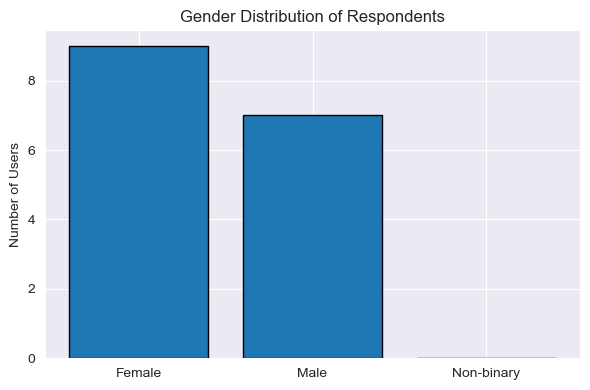

In [15]:
sex_codes = df.loc[3:, sex_col_index].dropna().astype(int)
gender_map = {1: "Female", 2: "Male", 3: "Non-binary"}
genders = sex_codes.map(gender_map)

order = ["Female", "Male", "Non-binary"]
counts = genders.value_counts().reindex(order, fill_value=0)

plt.figure(figsize=(6, 4))
plt.bar(counts.index, counts.values, edgecolor='black')
plt.title("Gender Distribution of Respondents")
plt.ylabel("Number of Users")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

    phq_total  bai_total  oci_total  stai_total
3           6         41         10          15
4          15         62         23          41
5          10         41         11          24
6           2         26          7          13
7           3         21          4           8
8           8         30         10          19
9           9         28         26          18
10          3         21          2           2
11         19         64         40          45
12         13         40         23          16
13          8         26         13          19
14          6         27         15          20
15          6         21          1           3
16         10         40         13          11
17         11         34         10          26
18          8         31         41          24


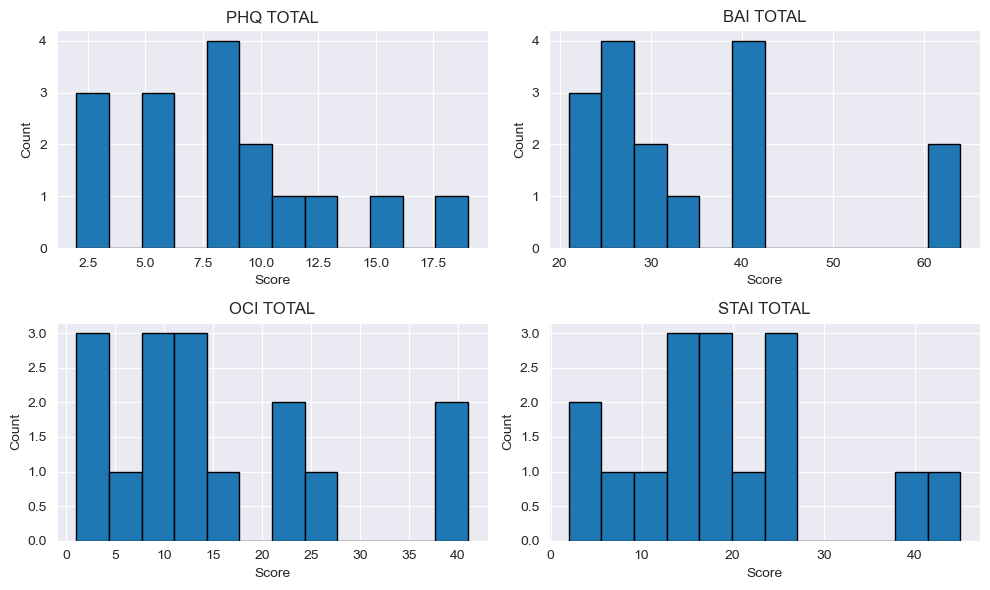

In [16]:
# Make sure these columns exist (you can do this before the loop)
new_cols = [
  "phq_total","phq_classification",
  "oci_total","oci_classification",
  "bai_total","bai_classification",
  "stai_total","stai_classification"
] + [f"BFI_{sub}" for sub in bfi_subscales]
# plus all ASSIST score and risk columns are already in df from the merge
# Numeric totals

# assemble totals into one DataFrame
totals = df.loc[3:, [f for f in ['phq_total','bai_total','oci_total','stai_total']]].astype(int)
print(totals)
plt.figure(figsize=(10,6))
for i, col in enumerate(totals.columns, 1):
    plt.subplot(2,2,i)
    plt.hist(totals[col], bins=12, edgecolor='black')
    plt.title(col.replace('_',' ').upper())
    plt.xlabel('Score')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

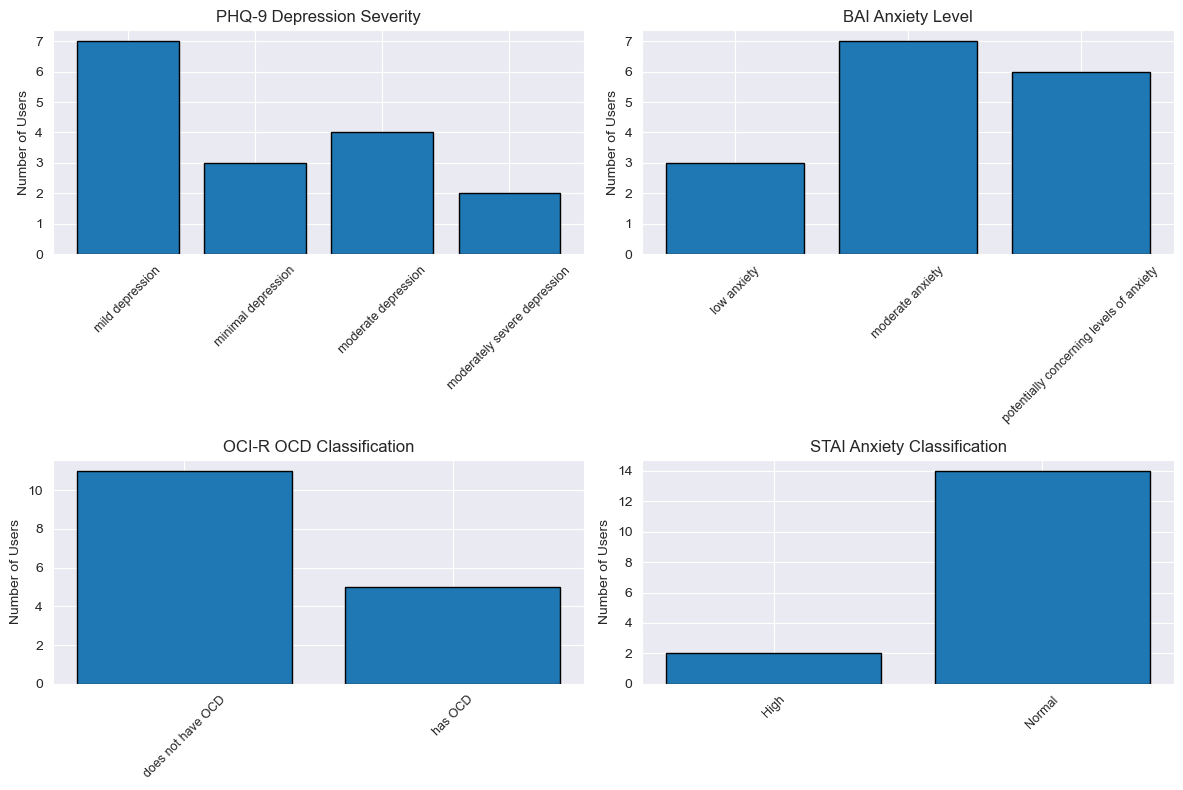

In [17]:
# List of your classification columns and plot titles
class_cols = [
    'phq_classification',
    'bai_classification',
    'oci_classification',
    'stai_classification'
]
titles = [
    'PHQ-9 Depression Severity',
    'BAI Anxiety Level',
    'OCI-R OCD Classification',
    'STAI Anxiety Classification'
]

# Make the 2×2 plot
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, col, title in zip(axes, class_cols, titles):
    # count each category
    counts = df.loc[3:, col].value_counts().sort_index()
    ax.bar(counts.index, counts.values, edgecolor='black')
    ax.set_title(title)
    ax.set_ylabel('Number of Users')
    ax.tick_params(axis='x', rotation=45, labelsize=9)

plt.tight_layout()
plt.show()

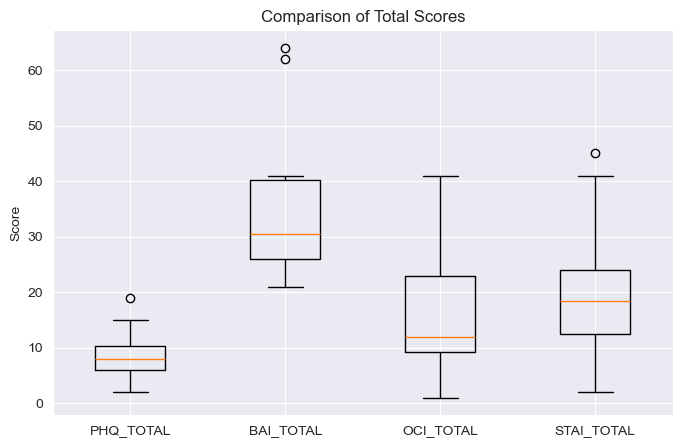

In [18]:
plt.figure(figsize=(8,5))
plt.boxplot([totals[c] for c in totals.columns], tick_labels=[c.upper() for c in totals.columns])
plt.title("Comparison of Total Scores")
plt.ylabel("Score")
plt.show()

/var/folders/17/xc696mzx7g5273rcc177w6980000gn/T/ipykernel_1647/2701723292.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


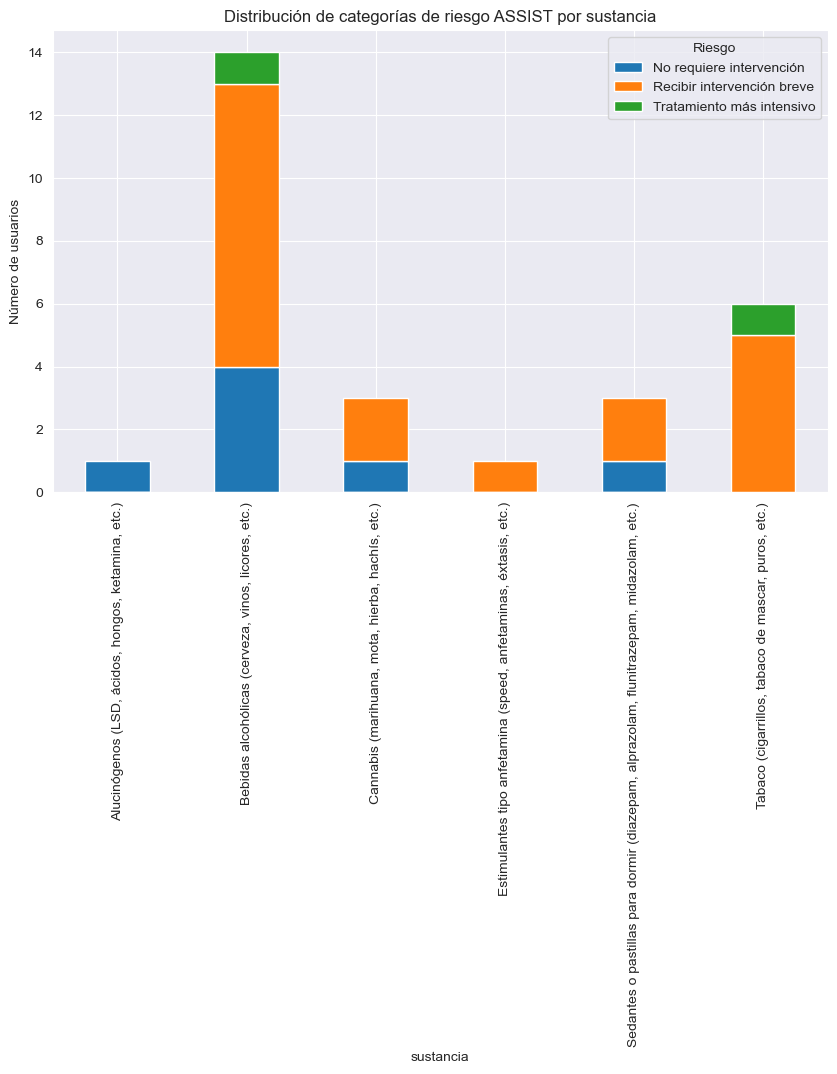

In [19]:
# reshape into long form
assist_long = assist_scores_df.melt(id_vars='username',
    value_vars=sub_names,
    var_name='sustancia', value_name='score'
).merge(
    assist_scores_df.melt(id_vars='username',
        value_vars=[f"{s}_risk" for s in sub_names],
        var_name='tmp', value_name='risk'
    ).assign(sustancia=lambda d: d['tmp'].str.replace('_risk',''))[['username','sustancia','risk']],
    on=['username','sustancia']
)

# Filter out individuals with a score of 0 on the sustancias
assist_long_filtered = assist_long[assist_long['score'] > 0]

# count
#counts = assist_long.groupby(['sustancia','risk']).size().unstack(fill_value=0)
counts = assist_long_filtered.groupby(['sustancia','risk']).size().unstack(fill_value=0)

counts.plot(kind='bar', stacked=True, figsize=(10,6))
plt.ylabel("Número de usuarios")
plt.title("Distribución de categorías de riesgo ASSIST por sustancia")
plt.legend(title="Riesgo", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

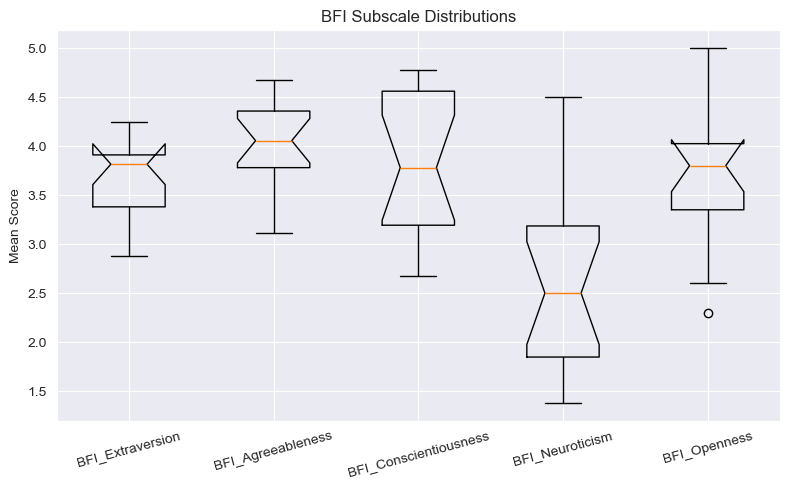

In [20]:
# assuming you've merged bfi subscale columns (Extraversion, Agreeableness, …) into df
bfi_cols = ["BFI_Extraversion","BFI_Agreeableness","BFI_Conscientiousness",
            "BFI_Neuroticism","BFI_Openness"]

plt.figure(figsize=(8,5))
plt.boxplot(
    [df.loc[3:, trait].astype(float) for trait in bfi_cols],
    tick_labels=bfi_cols,
    notch=True
)
plt.xticks(rotation=15)
plt.ylabel("Mean Score")
plt.title("BFI Subscale Distributions")
plt.tight_layout()
plt.show()

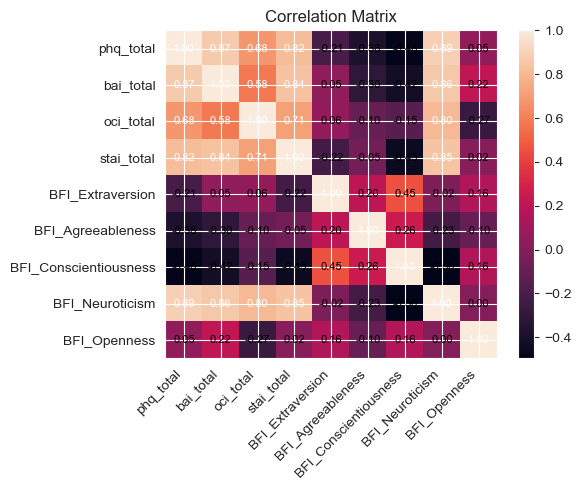

In [21]:
# collect a numeric matrix
num_cols = ["phq_total","bai_total","oci_total","stai_total"] + bfi_cols
mat = df.loc[3:, num_cols].astype(float).corr()

plt.figure(figsize=(6,5))
im = plt.imshow(mat, aspect="auto")
plt.colorbar(im)
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Correlation Matrix")
# annotate the cells
for i in range(len(num_cols)):
    for j in range(len(num_cols)):
        plt.text(j, i, f"{mat.iat[i,j]:.2f}", ha="center", va="center", fontsize=8, color="white" if abs(mat.iat[i,j])>0.5 else "black")
plt.tight_layout()
plt.show()